# Use Neuron Network model to predict stock daily return rates

## Prepare data

In [1]:
import pandas as pd
import warnings
import os
import sys
from sklearn.preprocessing import MinMaxScaler

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=info, 2=warning, 3=error
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore all future warning

In [2]:
df = pd.read_csv('../data/processed/VNINDEX_add_features.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6423 entries, 0 to 6422
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DTYYYYMMDD            6423 non-null   object 
 1   Ticker                6423 non-null   object 
 2   Open                  6423 non-null   float64
 3   High                  6423 non-null   float64
 4   Low                   6423 non-null   float64
 5   Close                 6423 non-null   float64
 6   Volume                6423 non-null   float64
 7   Outlier               6423 non-null   bool   
 8   daily_returns         6423 non-null   float64
 9   monthly_returns       6423 non-null   float64
 10  yearly_returns        6423 non-null   float64
 11  Net_advances          6423 non-null   int64  
 12  A/D                   6423 non-null   float64
 13  Schultz               6423 non-null   float64
 14  EMA19_net_adv         6423 non-null   float64
 15  EMA39_net_adv        

In [3]:
## Caculate the correlation matrix of the features
corr_df = df.copy()
corr_df = corr_df.drop(columns=['DTYYYYMMDD','Ticker','Open','High','Low','Volume','Close','Outlier','monthly_returns','yearly_returns'])
corr_matrix = corr_df.corr()

## Display the correlation matrix
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # ngăn DataFrame xuống dòng
pd.set_option('display.notebook_repr_html', True)
print(corr_matrix)


                      daily_returns  Net_advances       A/D   Schultz  EMA19_net_adv  EMA39_net_adv  McClellan_Oscillator      TRIN  StockAboveMA50       MA5      EMA5      MA10     EMA10      MA20     EMA20      MA50     EMA50     MA100    EMA100     MA200    EMA200
daily_returns              1.000000      0.629682  0.385782  0.360136       0.304914       0.221159              0.357898 -0.045105        0.078571 -0.025212 -0.021846 -0.030325 -0.027663 -0.034325 -0.032604 -0.040646 -0.038338 -0.042650 -0.041812 -0.044733 -0.044045
Net_advances               0.629682      1.000000  0.499066  0.634140       0.443493       0.321071              0.521660 -0.027070        0.148104  0.025248  0.027990  0.022683  0.024633  0.021810  0.022581  0.019807  0.020557  0.018636  0.019296  0.017505  0.019351
A/D                        0.385782      0.499066  1.000000  0.428697       0.156179       0.102137              0.203736 -0.022393        0.111282  0.114891  0.116383  0.115240  0.116160  0.11777

In [4]:
# So when we analyze the correlation matrix, we decide to use the features: Net_advances,A/D,Schultz, and McClellan_Oscillator
selected_features = ['Net_advances','A/D','Schultz','McClellan_Oscillator']
target_feature = ['daily_returns']

In [5]:
print(df[selected_features].min())
print('\n')
print(df[selected_features].max())

Net_advances           -95.000000
A/D                      0.000000
Schultz                  0.000000
McClellan_Oscillator   -12.763631
dtype: float64


Net_advances            94.000000
A/D                     93.000000
Schultz                  0.989474
McClellan_Oscillator    16.172283
dtype: float64


In [6]:
# Since these data was cleaned and had no outliers , we can use MinMaxScaler to scale the data
# The data range is from 0 to 1
scaler = MinMaxScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

In [7]:
print(df[selected_features].min())
print('\n')
print(df[selected_features].max())

Net_advances            0.0
A/D                     0.0
Schultz                 0.0
McClellan_Oscillator    0.0
dtype: float64


Net_advances            1.0
A/D                     1.0
Schultz                 1.0
McClellan_Oscillator    1.0
dtype: float64


## Train and predict with Neural Network model

In [8]:
# Import the libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np

tf.get_logger().setLevel('ERROR')

### Label the data

In [9]:
# Get the absolute path of the `src` folder
src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
# Add `src` to the system path
sys.path.insert(0, src_path)
# Import 
from models.DecisionTree import prepare_data_for_decision_tree

X,y = prepare_data_for_decision_tree(df, selected_features, target_feature,method_to_create_threshold='up_and_down')
print(X.shape)
print(y.shape)
split_index = int(len(X) * 0.8)  # Calculate the 80% split index

# Split the data
X_train, X_test = X[:split_index], X[split_index:]
y_train,y_test = y[:split_index], y[split_index:]

(6423, 4)
(6423,)


In [10]:
# Because sparse_categorical_crossentropy is used, the labels should be in the range of 0 to num_classes - 1
# Convert y_train and y_test to positive integer labels
y_train = y_train + 1
y_test = y_test + 1
np.unique(y_train),np.unique(y_test)

(array([0, 1, 2], dtype=int64), array([0, 1, 2], dtype=int64))

In [11]:
# Convert the data to one-hot encoding
y_train = tf.one_hot(y_train, depth=3)
y_test = tf.one_hot(y_test, depth=3)
print(y_train[0])

tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


In [12]:
# Check for NaN or Inf values in the training data
print("Checking X_train for NaN or Inf values:", np.any(np.isnan(X_train)), np.any(np.isinf(X_train)))
print("Checking y_train for NaN or Inf values:", np.any(np.isnan(y_train)), np.any(np.isinf(y_train)))

Checking X_train for NaN or Inf values: False False
Checking y_train for NaN or Inf values: False False


### Summary about some activation used in Neural Network

1. Heaviside
    - Define : H(x) = 0 if x < 0 else H(x) = 1 if x >= 0
    - Advantage : Easily to understand and deploy , simulate the real neutron.
    - Weakness : Gradient is appoximately 0 , can't use in deep learning.
    - Use case : If-else system.

2. Identity(Linear Activation)
    - Define : f(x) = x
    - Advantage : Easily to caculate .
    - Weakness : Entire network wil become a __linear function__ , no nonlinear power , it can't learn complex relationships .
    - Use case : Output layers in regression problem.

3. ReLU (Rectified Linear Unit)
    - Define: f(x) = max(0,x)
    - Advantage : Easily and simply to caculate ; Decreasing the vanishing gradient phenomenon in machine learning (not like sigmoid or tanh) . 
    - Weakness : If the x is negative , it can't be updated
    - Use case : Hidden layers in CNN , MLP , ....; Some model that needs training quickly and great depth.

4. Sigmoid 
    - Define: f(x) = 1/(1+e^(-x))
    - Advantage : Output from 0 to 1 => good for 2 label classification problem . 
    - Weakness : Vanishing gradient , if x too high or too low , the learning rate is kind of slow ; Output is not zero-centered.
    - Use case : Output layer for Binary classification .

5. Tanh(Hyperbolic Tangent)
    - Define : f(x) = (e^x-e^-x)/(e^x+e^-x)
    - Advantage : Output from 0 to 1, zero-centered.
    - Weakness : Vanishing gradient (less than Sigmoid).
    - Use case : Hidden layers in small model , traditional RNN .
    

### Here is a quick look of them

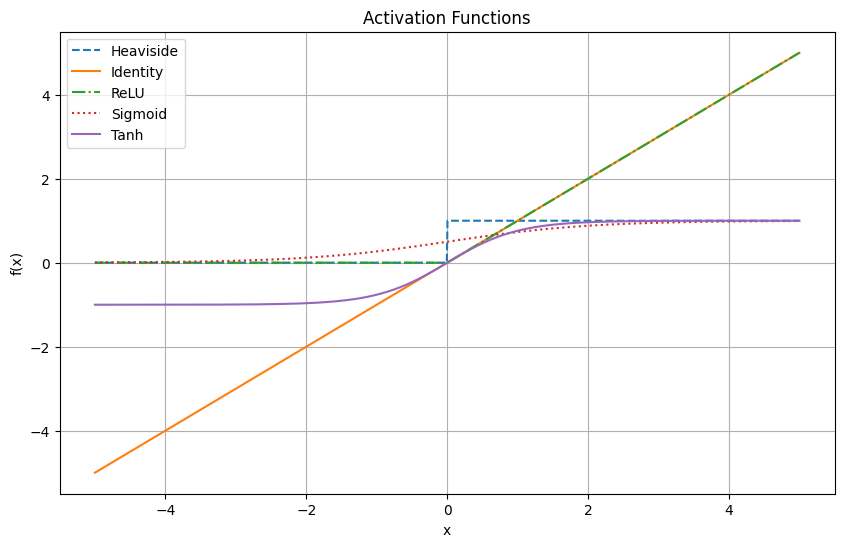

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Định nghĩa các hàm kích hoạt
def heaviside(x):
    return np.where(x >= 0, 1, 0)

def identity(x):
    return x

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

# Tạo dữ liệu cho trục x
x = np.linspace(-5, 5, 1000)

# Tính giá trị các hàm kích hoạt
y_heaviside = heaviside(x)
y_identity = identity(x)
y_relu = relu(x)
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(x, y_heaviside, label='Heaviside', linestyle='--')
plt.plot(x, y_identity, label='Identity', linestyle='-')
plt.plot(x, y_relu, label='ReLU', linestyle='-.')
plt.plot(x, y_sigmoid, label='Sigmoid', linestyle=':')
plt.plot(x, y_tanh, label='Tanh', linestyle='-')

# Thêm tiêu đề và nhãn
plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()

# Lưu biểu đồ
plt.savefig('activation_functions.png')

### Build the model

In [ ]:
"""
In this code , we will deploy a simple neural network with 1 input layer , 1 hidden layer and 1 output layer.
The input layer will have 4 neurons , as we choose 4 features to train model.

We will use some typical number of units for the model:
    - The first hidden layer will have 64 neurons
    - The second hidden layer will have 16 neurons
    - The output layer will have 3 neurons, corresponding to the three classes of the target variable.
The activation function for the first hidden layer is ReLU, which is a common choice for hidden layers in neural networks.
The second hidden layer also uses ReLU as the activation function.
The output layer uses softmax activation function, which is suitable for multi-class classification problems.

The model will be trained for 50 epochs .

We use categorical_crossentropy as the loss function, which is commonly used for multi-class classification problems.
The result of prediction will be a probability distribution over the three classes (something like 0.15, 0.74, 0.23).
The optimizer is Adam optimizer, which is a popular choice for training deep learning models.
"""

model = keras.Sequential([
    # The input layer will have 4 neurons , as we choose 4 features to train model.
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train and predict with model

In [14]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
161/161 [==============================] - 0s 716us/step - loss: 0.9711 - accuracy: 0.5197
Epoch 2/50
161/161 [==============================] - 0s 612us/step - loss: 0.9182 - accuracy: 0.5453
Epoch 3/50
161/161 [==============================] - 0s 604us/step - loss: 0.9012 - accuracy: 0.5452
Epoch 4/50
161/161 [==============================] - 0s 606us/step - loss: 0.8939 - accuracy: 0.5450
Epoch 5/50
161/161 [==============================] - 0s 659us/step - loss: 0.8923 - accuracy: 0.5453
Epoch 6/50
161/161 [==============================] - 0s 609us/step - loss: 0.8887 - accuracy: 0.5452
Epoch 7/50
161/161 [==============================] - 0s 598us/step - loss: 0.8877 - accuracy: 0.5446
Epoch 8/50
161/161 [==============================] - 0s 599us/step - loss: 0.8842 - accuracy: 0.5457
Epoch 9/50
161/161 [==============================] - 0s 608us/step - loss: 0.8829 - accuracy: 0.5455
Epoch 10/50
161/161 [==============================] - 0s 587us/step - loss: 0.880

In [15]:
y_pred = model.predict(X_test)
print(y_pred)
print('Score:', model.evaluate(X_test, y_test, verbose=0)[1])
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred -1
y_predict = np.pad(y_pred,(len(y_train),0),'constant',constant_values=0)

41/41 [==============================] - 0s 626us/step
[[0.6000139  0.22848697 0.1714991 ]
 [0.4543155  0.45965528 0.08602925]
 [0.671872   0.06139563 0.2667323 ]
 ...
 [0.6606307  0.08292524 0.256444  ]
 [0.672902   0.04622131 0.2808768 ]
 [0.67648065 0.14650048 0.17701888]]
Score: 0.574319064617157


In [16]:
print(y_predict)

[ 0  0  0 ... -1 -1 -1]


## Trade with the predict

In [17]:
from trade_stocks.trade import Trading

trading = Trading()
trade_signal = trading.generate_trade_signal(y_predict)
print(trade_signal)
finally_capital = trading.execute_trade(trade_signal,np.array(df['Close']))
print(finally_capital)
total_profit,total_trade_number,win_rate,profit_factor = trading.performance()

print(f"Total profit: {total_profit}")
print(f"Total trade number: {total_trade_number}")
print(f"Win rate: {win_rate}")
print(f"Profit factor: {profit_factor}")


[0. 0. 0. ... 1. 1. 1.]
2004413.8835999998
Total profit: 4413.883599999826
Total trade number: 9
Win rate: 0.5555555555555556
Profit factor: 1.8683589738787425
